In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

le = preprocessing.LabelEncoder()

Using TensorFlow backend.
/home/nad/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df=pd.read_csv("housing_prices_grand_tunis.csv")

In [3]:
df.dropna(axis=0, subset=['price','address'], inplace=True)

In [4]:
def fix_price(x):
    if isinstance(x,int) or isinstance(x,float):return x
    if x.split()[-1]=="DT": return int(x[:-3].replace(" ",""))
    if x.split()[-1]=="Nuit": return 30*int(x[:-10].replace(" ",""))
    if x.split()[-1]=="Mois": return int(x[:-10].replace(" ",""))
    if x.split()[-1]=="Semaine": return 4*int(x[:-13].replace(" ",""))
    

In [5]:
def fix_number(x):
    if str(x) == "nan": return x
    if str(x)[-1]=="+": 
        x=int(str(x).strip()[:-1])
    if int(x)>10: 
        x=None
        return x
    return int(x)

In [6]:
def cast_type(x):
#     print(x)
    if x=="vente": return 0
    return 1

In [7]:
# Can be used to filter by type (only keep rent /sale row)
df = df[df.type == 'vente']

In [8]:
# remove DT, /Mois, /Nuit...
df['price']=df['price'].map(fix_price)
# remove '+' signs
df['bathrooms']=df['bathrooms'].map(fix_number)
df['total_rooms']=df['total_rooms'].map(fix_number)
df['rooms']=df['rooms'].map(fix_number)
df['gov']=df['gov'].apply(lambda x: x.strip())
# replace vente/location by 0/1
df['type']=df['type'].map(cast_type)
# if one of the 2 fields is empty try to fill it with the other one
df['rooms'].fillna(df['total_rooms'],inplace=True)
df['total_rooms'].fillna(df['rooms'],inplace=True)
df['living_area'].fillna(df['total_area'],inplace=True)
df['total_area'].fillna(df['living_area'],inplace=True)
# remove row containing any non-appartment-related word
df = df[df['title'].apply(lambda t: True if all(word not in t.split() for word in ["Terrain", "terrain", "أرض", "ارض", "lot", "lots"]) else False)]
# remove areas greater than 700 m²
# df = df[df.total_area < 700]
# label encoders for gov and address
# df[['gov','address']]=df[['gov','address']].apply(lambda x: le.fit_transform(x))
df = pd.get_dummies(df, columns=['gov', 'address'])
df = df.drop(columns={"gov_Ariana","address_Tebourba"})

In [9]:
df.loc[df['type']==0,'price']=df.loc[df['type']==0,'price'].apply(lambda x: 1000*x if x<1000 else x)

In [10]:
df['total_rooms'].fillna(df['total_rooms'].median(), inplace=True)
df['rooms'].fillna(df['rooms'].median(), inplace=True)
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['living_area'].fillna(df['living_area'].median(), inplace=True)
df['total_area'].fillna(df['total_area'].median(), inplace=True)

In [11]:
df

,price,type,title,bathrooms,total_rooms,living_area,total_area,rooms,gov_Ben Arous,gov_Manouba,...,address_Médina,address_Mégrine,address_Oued Ellil,address_Radès,address_Raoued,address_Sidi Daoud,address_Sidi El Béchir,address_Sidi Hassine,address_Sidi Thabet,address_Séjoumi
3,170000,0,Appart Kalra,2.0,1.0,90.0,90.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,300000,0,Appart Karma,2.0,3.0,120.0,120.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1150000,0,Loft Panorama,2.0,3.0,360.0,360.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,412000,0,Des appartement haut standing,1.0,4.0,157.0,168.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,950000,0,Av bureau a la marsa,3.0,6.0,50.0,50.0,6.0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,680000,0,Av duplex au jardin de carthage,1.0,4.0,252.0,252.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,504900,0,Av un appartement s3 au jardin de carthage,1.0,4.0,187.0,187.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,980000,0,Av duplex gammarth,2.0,4.0,200.0,200.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1700000,0,Av villa marina gammarth,1.0,4.0,370.0,370.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,545400,0,Av un appartement au jardin de carthage,1.0,4.0,202.0,202.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Creating the models

In [12]:
x = df[list(filter(lambda x: x not in ['price', 'title', 'type'], df.columns))] # predictor
y = df.price # response
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Linear Regression

In [13]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
print("Accuracy: ", 100 * linreg.score(x_test,y_test), "%" ) 

Accuracy:  43.13883744475262 %


# Decision Tree

In [15]:
clf = DecisionTreeClassifier(criterion = "entropy",max_depth=5, min_samples_leaf=5)
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
print("Accuracy: ", 100 * clf.score(x_test,y_test), "%" ) 

Accuracy:  5.240174672489083 %


# Random forest

In [17]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
print("Accuracy: ", 100 * rf.score(x_test, y_test), "%" ) 

Accuracy:  82.72982964084214 %


# ANN

In [19]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim = 37, init = 'uniform', activation = 'relu', input_dim = len(x.columns)))

# Adding the second hidden layer
classifier.add(Dense(output_dim = 37, init = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'relu'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(x_train, y_train, batch_size = 10, nb_epoch = 200)

# Part 3 - Making the predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(x_test)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=71, units=37, kernel_initializer="uniform")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=37, kernel_initializer="uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=1, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/200
916/916 [==============================] - 0s 267us/step - loss: -194962132.2717 - acc: 0.0000e+00
Epoch 2/200
916/916 [==============================] - 0s 92us/step - loss: -225789726.9116 - acc: 0.0000e+00
Epoch 3/200
916/916 [==============================] - 0s 87us/step - loss: -226507713.5448 - acc: 0.0000e+00
Epoch 4/200
916/916 [==============================] - 0s 77us/step - loss: -227057432.4449 - acc: 0.0000e+00
Epoch 5/200
916/916 [==============================] - 0s 96us/step - loss: -227689355.0579 - acc: 0.0000e+00
Epoch 6/200
916/916 [==============================] - 0s 77us/step - loss: -228264409.7276 - acc: 0.0000e+00
Epoch 7/200
916/916 [==============================] - 0s 87us/step - loss: -229436668.3346 - acc: 0.0000e+00
Epoch 8/200
916/916 [==============================] - 0s 81us/step - loss: -244959706.5480 - acc: 0.0000e+00
Epoch 9/200
916/916 [==============================] - 0s 92us/step - loss: -244962472.1889 - acc: 0.0000e+00
Epoch 10/

916/916 [==============================] - 0s 89us/step - loss: -244962470.9460 - acc: 0.0000e+00
Epoch 75/200
916/916 [==============================] - 0s 94us/step - loss: -244962470.6119 - acc: 0.0000e+00
Epoch 76/200
916/916 [==============================] - 0s 107us/step - loss: -244962473.1376 - acc: 0.0000e+00
Epoch 77/200
916/916 [==============================] - 0s 97us/step - loss: -244962471.3379 - acc: 0.0000e+00
Epoch 78/200
916/916 [==============================] - 0s 109us/step - loss: -244962469.4858 - acc: 0.0000e+00
Epoch 79/200
916/916 [==============================] - 0s 77us/step - loss: -244962473.9127 - acc: 0.0000e+00
Epoch 80/200
916/916 [==============================] - 0s 109us/step - loss: -244962479.3450 - acc: 0.0000e+00
Epoch 81/200
916/916 [==============================] - 0s 100us/step - loss: -244962471.9760 - acc: 0.0000e+00
Epoch 82/200
916/916 [==============================] - 0s 98us/step - loss: -244962472.4110 - acc: 0.0000e+00
Epoch 83/2

916/916 [==============================] - 0s 77us/step - loss: -244962473.4121 - acc: 0.0000e+00
Epoch 148/200
916/916 [==============================] - 0s 133us/step - loss: -244962473.7211 - acc: 0.0000e+00
Epoch 149/200
916/916 [==============================] - 0s 163us/step - loss: -244962473.6103 - acc: 0.0000e+00
Epoch 150/200
916/916 [==============================] - 0s 140us/step - loss: -244962476.6539 - acc: 0.0000e+00
Epoch 151/200
916/916 [==============================] - 0s 99us/step - loss: -244962476.0600 - acc: 0.0000e+00
Epoch 152/200
916/916 [==============================] - 0s 82us/step - loss: -244962474.6632 - acc: 0.0000e+00
Epoch 153/200
916/916 [==============================] - 0s 84us/step - loss: -244962470.3777 - acc: 0.0000e+00
Epoch 154/200
916/916 [==============================] - 0s 76us/step - loss: -244962469.2003 - acc: 0.0000e+00
Epoch 155/200
916/916 [==============================] - 0s 127us/step - loss: -244962475.7959 - acc: 0.0000e+00
Ep

In [25]:
import pickle
pickle.dump(linreg, open("linreg.sav", 'wb'))
pickle.dump(clf, open("dt.sav", 'wb'))
pickle.dump(rf, open("rf.sav", 'wb'))

In [27]:
a=pickle.load(open("rf.sav", 'rb'))

In [29]:
a.score(x_test,y_test)

0.8272982964084215

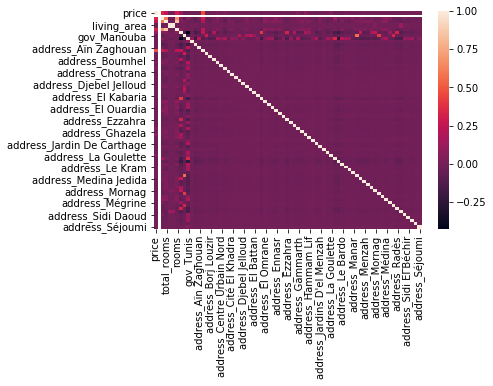

In [20]:
corr = df.corr()
sns.heatmap(corr)


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdc6c492d68>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdc6c4a1438>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdc6c492be0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdc6c4a1ac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdc6c4a1e10>],
 'means': []}

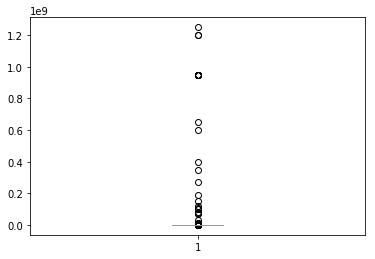

In [21]:
plt.boxplot(df.price)

In [22]:
list(filter(lambda x: x not in ['price', 'title', 'type'], df.columns))


['bathrooms',
 'total_rooms',
 'living_area',
 'total_area',
 'rooms',
 'gov_Ben Arous',
 'gov_Manouba',
 'gov_Tunis',
 'address_Agba',
 'address_Ariana Ville',
 'address_Aïn Zaghouan',
 'address_Borj Cedria',
 'address_Borj El Amri',
 'address_Borj Louzir',
 'address_Boumhel',
 'address_Carthage',
 'address_Centre Urbain Nord',
 'address_Centre Ville - Lafayette',
 'address_Chotrana',
 'address_Cité El Khadra',
 'address_Cité Olympique',
 'address_Denden',
 'address_Djebel Jelloud',
 'address_Djedeida',
 'address_Douar Hicher',
 'address_El Battan',
 'address_El Kabaria',
 'address_El Mourouj',
 'address_El Omrane',
 'address_El Omrane supérieur',
 'address_El Ouardia',
 'address_Ennasr',
 'address_Ettadhamen',
 'address_Ettahrir',
 'address_Ezzahra',
 'address_Ezzouhour',
 'address_Fouchana',
 'address_Gammarth',
 'address_Ghazela',
 'address_Hammam Chott',
 'address_Hammam Lif',
 'address_Hraïria',
 'address_Jardin De Carthage',
 "address_Jardins D'el Menzah",
 'address_Kalaât El An